# <h1 align="center"><font color = #0081be>Lighthouse | Cientista de Dados | Indicium 🌎🚀</font></h1>

## <a><font color = #0081be>**Objetivos**</font></a>
A empresa Adventure Works (AW) é uma indústria de bicicletas com mais de 500 produtos distintos, 20.000 clientes e 31.000 pedidos. Nesse desafio, será realizada uma previsão de demanda, a fim, de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima.

> <a><font color = #0081be>**1.**</font></a> A fim de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima, faça uma previsão sobre a demanda dos próximos 3 meses de cada produto em cada loja. Além disso, aponte se há ou não a presença de sazonalidade em algum produto de sua escolha.

>  <a><font color = #0081be>**2.**</font></a> Seria possível resolver este problema através de uma abordagem utilizando modelos de regressão? Se sim, qual demonstra melhor resultado? Justifique utilizando métricas de avaliação.
   
> <a><font color = #0081be>**3.**</font></a> Os novos centros de distribuição passaram a ser divididos em províncias nos EUA e em países no resto do mundo. Qual desses grupos apresentou mais crescimento em demanda nos três meses previstos no item 1?
   
> <a><font color = #0081be>**4.**</font></a> Um novo fornecedor de luvas, que agora engloba toda a produção mundial, precisa ter uma estimativa de quantos zíperes precisa pedir para os próximos 3 meses. Levando em consideração que são necessários 2 zíperes por par, quantos seriam necessários?

## Instalações e importações das bibliotecas

In [1]:
!pip install statsforecast
!pip install hierarchicalforecast

In [2]:
!pip install unidecode

In [3]:
!pip install google-cloud-bigquery

In [4]:
!pip install pandas-gbq

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from unidecode import unidecode
import xgboost as xgb

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from statsmodels.formula.api import ols

from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Naive, SeasonalNaive, HoltWinters

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import LabelEncoder

from google.cloud import bigquery

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Carregamento dos Dados do BigQuery

In [6]:
from google.colab import auth
auth.authenticate_user()

In [7]:
client = bigquery.Client()

project_id = 'projectaw'
dataset_id = 'dev_andressa_marts'
table_id = 'fct_sales2'

table_ref = client.get_table(f"{project_id}.{dataset_id}.{table_id}")

In [8]:
df = pd.read_gbq(f"select * from `{project_id}.{dataset_id}.{table_id}`", project_id=project_id)

## Informações sobre o DataFrame

In [9]:
df.head()

,fct_sales_sk,sales_order_id,customer_fk,location_fk,credit_card_fk,reason_fk,product_fk,order_date,ship_date,status_sales,...,Price,Manufacturer,Quality,Promotion,Review,Other,Television,product_name,product_subcategory_name,product_category_name
0,0040e65231ec025e6eddbd294178418e,47883,77bd8919603ba3c00e26d92710171b8c,f24a090f0e287d36779dac5b428d0064,8e03849e6e9b743611d4f3d35aca26cc,97ce84b684875fd93dd134c18099ade9,67d96d458abdef21792e6d8e590244e7,2012-09-19,2012-09-26,Enviado,...,0,0,0,0,1,0,0,"Mountain-200 Silver, 38",Bicicletas de montanha,Bicicletas
1,0096bf74b1207b35491036089394152c,53565,4daf3131a3b73237edccfc5c6acbd7ad,7eacb532570ff6858afd2723755ff790,7c4121d27bf970f00f1dfdcee8f43a5d,None,67d16d00201083a2b118dd5128dd6f59,2013-07-31,2013-08-07,Enviado,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Hitch Rack - 4-Bike,Bicicletários,Acessórios
2,014e761cb1480ccf0ef4070684d5b390,53475,2dc3f07e184f0f5c1cdcf6b618487fb9,b4a528955b84f584974e92d025a75d1f,95e2b3bc377ab32c26e010300ce0081b,None,3df1d4b96d8976ff5986393e8767f5b2,2013-07-31,2013-08-07,Enviado,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,ML Road Pedal,Pedais,Componentes
3,016eda1fc6c958d4028ee4a6374fa9aa,47456,e797b9be4cf8c1f1de10c2fba822e99a,851ddf5058cf22df63d3344ad89919cf,babcff88f8be8c4795bd6f0f8cccca61,None,d58072be2820e8682c0a27c0518e805e,2012-07-31,2012-08-07,Enviado,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,ML Headset,Fones de ouvido,Componentes
4,030d38a007da53bca1f9da605fe8c71b,53577,449ddfa2100f691195ad1b10e5bcd846,a532400ed62e772b9dc0b86f46e583ff,fdff71fcab656abfbefaabecab1a7f6d,None,c4b31ce7d95c75ca70d50c19aef08bf1,2013-07-31,2013-08-07,Enviado,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,HL Touring Handlebars,Guidão,Componentes


In [10]:
df.shape

(121317, 44)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121317 entries, 0 to 121316
Data columns (total 44 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   fct_sales_sk              121317 non-null  object 
 1   sales_order_id            121317 non-null  Int64  
 2   customer_fk               121317 non-null  object 
 3   location_fk               121317 non-null  object 
 4   credit_card_fk            118744 non-null  object 
 5   reason_fk                 53969 non-null   object 
 6   product_fk                121317 non-null  object 
 7   order_date                121317 non-null  dbdate 
 8   ship_date                 121317 non-null  dbdate 
 9   status_sales              121317 non-null  object 
 10  onlineorderflag           121317 non-null  boolean
 11  subtotal                  121317 non-null  float64
 12  taxamt                    121317 non-null  float64
 13  freight                   121317 non-null  f

**Informações estatísticas para variáveis numéricas**

In [12]:
df.describe()

,sales_order_id,subtotal,taxamt,freight,totaldue,orderqty,unitprice,unitpricediscount,amount_paid_product,standardcost,...,safetystocklevel,reorderpoint,daystomanufacture,Price,Manufacturer,Quality,Promotion,Review,Other,Television
count,121317.0,121317.000000,121317.000000,121317.000000,121317.000000,121317.0,121317.000000,121317.000000,121317.000000,121317.000000,...,121317.0,121317.0,121317.0,53969.0,53969.0,53969.0,53969.0,53969.0,53969.0,53969.0
mean,57827.363782,21402.362873,2075.630531,648.634554,24126.627959,2.26608,465.093496,0.002826,909.780544,373.686117,...,169.938162,127.453622,1.486675,0.884452,0.033686,0.028739,0.13693,0.030388,0.067687,0.013526
std,9009.147902,28509.182428,2795.708770,873.658983,32173.502712,2.491323,751.885081,0.024811,1705.221114,554.114063,...,205.181248,153.885936,1.805957,0.319685,0.180421,0.167073,0.343777,0.171654,0.25121,0.115514
min,43659.0,1.374000,0.109900,0.034400,1.518300,1.0,1.328200,0.000000,1.374000,0.856500,...,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,49884.0,564.480000,45.237600,14.136800,623.750400,1.0,21.490000,0.000000,24.990000,9.159300,...,4.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,57029.0,2518.980000,205.193600,64.123000,2785.517200,1.0,49.990000,0.000000,134.982000,38.492300,...,100.0,75.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,65490.0,37202.781200,3598.309200,1124.471600,41890.970300,3.0,602.346000,0.000000,1120.490000,486.706600,...,500.0,375.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
max,75123.0,163930.394300,17948.518600,5608.912100,187487.825000,44.0,3578.270000,0.400000,30990.310000,2171.294200,...,500.0,375.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**Informações estatísticas para as variáveis categóricas**

In [13]:
df.describe(include='object').T

,count,unique,top,freq
fct_sales_sk,121317,121317,0040e65231ec025e6eddbd294178418e,1
customer_fk,121317,19119,ff23707fd0625ccdfb4f42ddbaf1a649,530
location_fk,121317,19119,15de21c670ae7c3f6f3f1f37029303c9,530
credit_card_fk,118744,18384,b31f0c758bb498b5d56b5fea80f313a7,530
reason_fk,53969,23012,e2d5b645da58c9ff438ee2a7f168ae61,8
product_fk,121317,266,22fb0cee7e1f3bde58293de743871417,4688
status_sales,121317,1,Enviado,121317
customer_person_type,121317,2,Contato da loja,60919
name_store,60919,633,Vigorous Exercise Company,530
city,121317,535,Toronto,3498


## Tratamento de Valores Nulos

In [14]:
df.isnull().sum()

fct_sales_sk                    0
sales_order_id                  0
customer_fk                     0
location_fk                     0
credit_card_fk               2573
reason_fk                   67348
product_fk                      0
order_date                      0
ship_date                       0
status_sales                    0
onlineorderflag                 0
subtotal                        0
taxamt                          0
freight                         0
totaldue                        0
orderqty                        0
unitprice                       0
unitpricediscount               0
amount_paid_product             0
standardcost                    0
listprice                       0
makeflag                        0
finishedgoodsflag               0
safetystocklevel                0
reorderpoint                    0
daystomanufacture               0
customer_person_type            0
name_store                  60398
city                            0
postalcode    

**Excluindo as *features* dos identificadores únicos**

In [15]:
df = df.drop('fct_sales_sk', axis=1)
df = df.drop('sales_order_id', axis=1)
df = df.drop('customer_fk', axis=1)
df = df.drop('location_fk', axis=1)
df = df.drop('credit_card_fk', axis=1)
df = df.drop('reason_fk', axis=1)
df = df.drop('product_fk', axis=1)
df = df.drop('status_sales', axis=1)
df = df.drop('cardtype', axis=1)
df = df.drop('ship_date', axis=1)

**Para o tratamento dos dados Missing (NaN) iremos considerar que os valores ausentes das seguintes *features* são representados por 0.**

In [16]:
df['Price'] = df['Price'].replace(np.nan, 0)
df['Manufacturer'] = df['Manufacturer'].replace(np.nan, 0)
df['Quality'] = df['Quality'].replace(np.nan, 0)
df['Promotion'] = df['Promotion'].replace(np.nan, 0)
df['Review'] = df['Review'].replace(np.nan, 0)
df['Other'] = df['Other'].replace(np.nan, 0)
df['Television'] = df['Television'].replace(np.nan, 0)

**Os valores ausentes para a loja são representados por uma compra de um cliente individual.**

In [17]:
df['name_store'] = df['name_store'].replace(np.nan, 'Cliente individual')

## Pré-Processamento dos Dados

In [18]:
df['order_date'] = pd.to_datetime(df['order_date'])
df["month"] = pd.to_datetime(df["order_date"]).dt.to_period('M').dt.to_timestamp()

In [19]:
df['name_store'] = df['name_store'].str.replace('/', ' ')
df['product_name'] = df['product_name'].str.replace('/', ' ')
df['product_name'] = df['product_name'].str.replace('-', ' ')
df['country_region_name'] = df['country_region_name'].apply(lambda x: unidecode(str(x)))
df['product_subcategory_name'] = df['product_subcategory_name'].apply(lambda x: unidecode(str(x)))

## Análise Exploratória de Dados (EDA)

In [20]:
def plot_annotate(ax, title):
    """ Adicionar anotações nos gráficos.

    Args:
        ax: Objeto do tipo Axes do Matplotlib
        title (string): Título do gráfico
    Returns:
        None
    """

    for rect in ax.patches:
        ax.annotate(rect.get_height(),
                (rect.get_x() + rect.get_width()/2, rect.get_height()),
                ha='center', va='baseline', fontsize=8, color=neutral_500,
                xytext=(0, 1), textcoords="offset points")
    ax.set_title(title)


# Cores
cerulean="#0081be"
web_orange="#f7a600"
port_gore="#1a2144"
chambray="#333b8f"
sandal="#9c8b64"
curious_blue="#13a0db"
cornflower="#88bce7"
abbey="#1b1d1e"
neutral_500="#878b97"

In [21]:
monthly_sales = (
    df
    .groupby("month")["orderqty"].sum()
    .reset_index()
)

monthly_sales.head()

,month,orderqty
0,2011-05-01,825
1,2011-06-01,141
2,2011-07-01,2209
3,2011-08-01,2904
4,2011-09-01,157


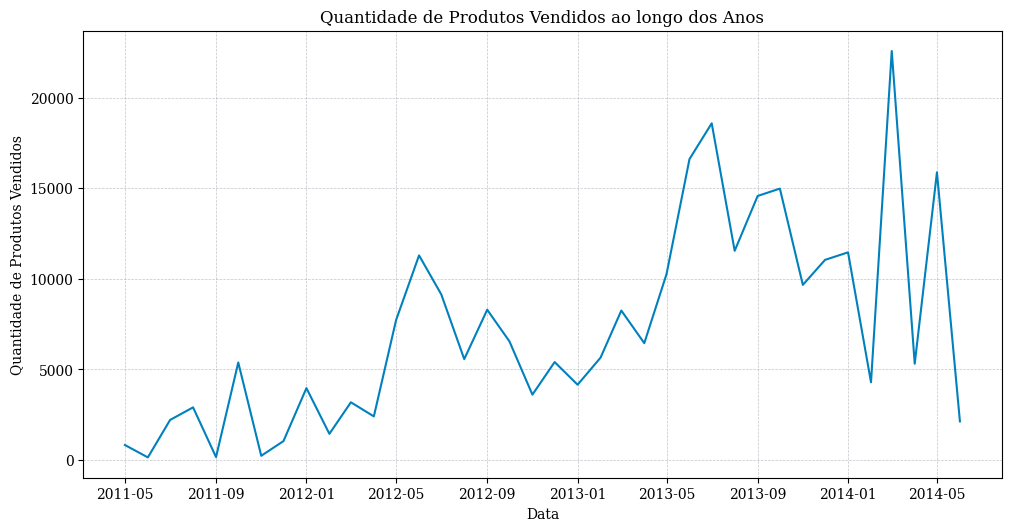

In [22]:
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = monthly_sales.sort_values('month', ascending=True)

xs = df_sorted['month']
ys = df_sorted['orderqty']

plt.plot(xs, ys, color=cerulean)

plt.title('Quantidade de Produtos Vendidos ao longo dos Anos')
plt.xlabel('Data')
plt.ylabel('Quantidade de Produtos Vendidos')

plt.grid(True, linestyle='--', linewidth=0.5, color=neutral_500, alpha=0.5)

plt.show()

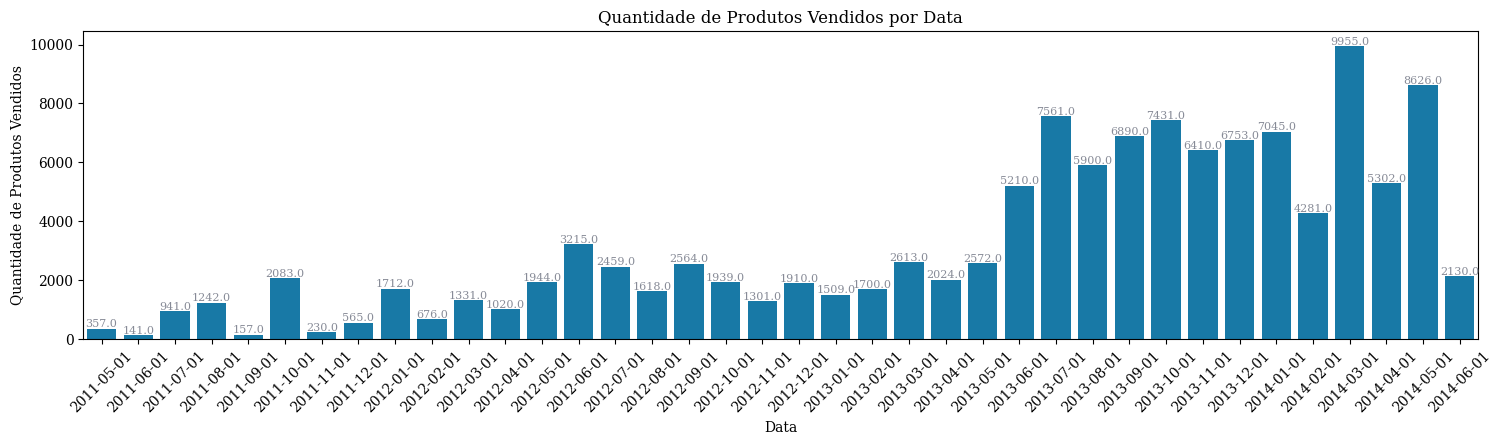

In [23]:
df['month'] = pd.to_datetime(df['month'])
df_sorted = df.sort_values('month')

fig, axs = plt.subplots(figsize=(18, 4))
ax = sns.countplot(x='month', data=df_sorted, color=cerulean)
plt.xticks(rotation=45)

plt.xlabel('Data')
plt.ylabel('Quantidade de Produtos Vendidos')
plot_annotate(ax, 'Quantidade de Produtos Vendidos por Data')
plt.show()

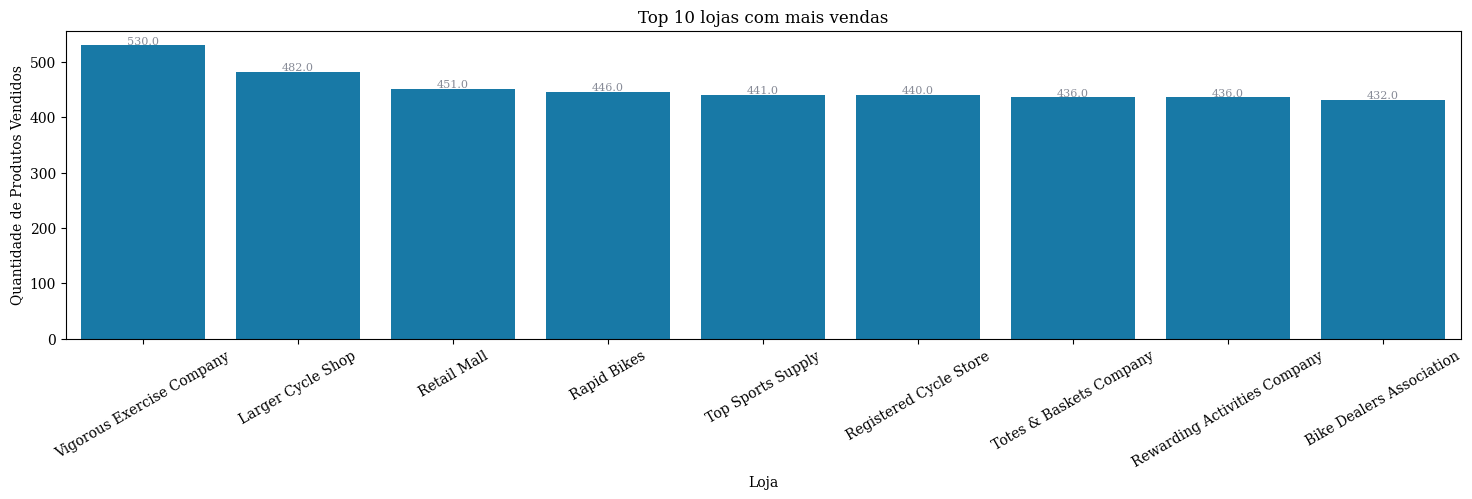

In [24]:
top_stores = df['name_store'].value_counts().nlargest(10).index
top_stores = top_stores[1:]
df_top_stores = df[df['name_store'].isin(top_stores)]
df_top_stores['name_store'] = pd.Categorical(df_top_stores['name_store'], categories=top_stores, ordered=True)


fig, axs = plt.subplots(figsize=(18, 4))
ax = sns.countplot(x='name_store', data=df_top_stores, color=cerulean)
plt.xticks(rotation=30)
plot_annotate(ax, 'Top 10 lojas com mais vendas')
plt.xlabel('Loja')
plt.ylabel('Quantidade de Produtos Vendidos')
plt.show()


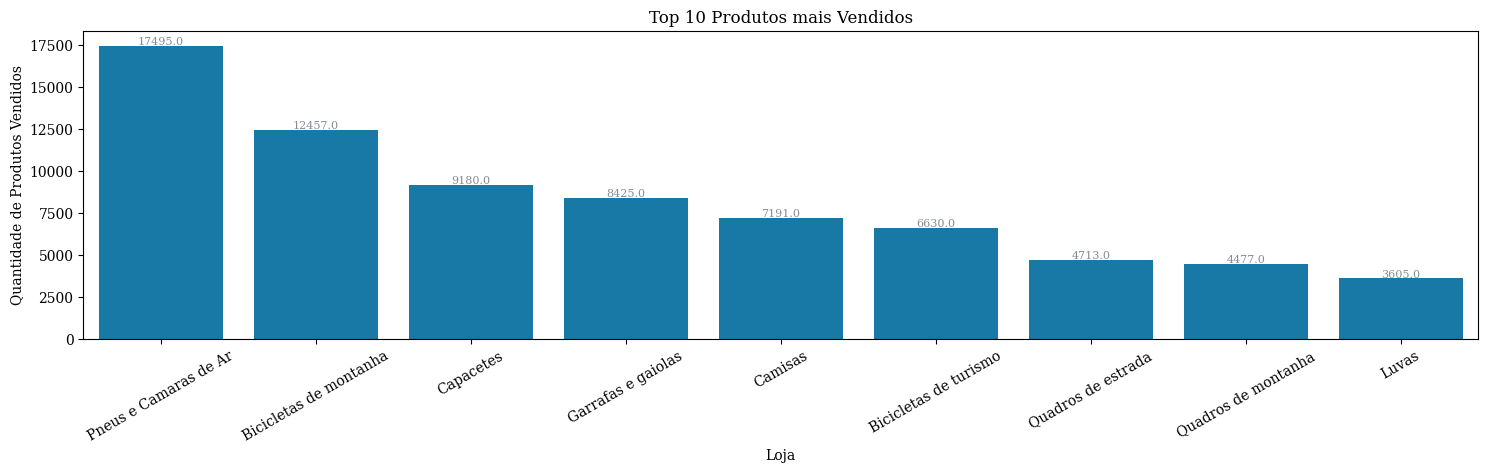

In [25]:
top_stores = df['product_subcategory_name'].value_counts().nlargest(10).index
top_stores = top_stores[1:]
df_top_stores = df[df['product_subcategory_name'].isin(top_stores)]
df_top_stores['product_subcategory_name'] = pd.Categorical(df_top_stores['product_subcategory_name'], categories=top_stores, ordered=True)


fig, axs = plt.subplots(figsize=(18, 4))
ax = sns.countplot(x='product_subcategory_name', data=df_top_stores, color=cerulean)
plt.xticks(rotation=30)
plot_annotate(ax, 'Top 10 Produtos mais Vendidos')
plt.xlabel('Loja')
plt.ylabel('Quantidade de Produtos Vendidos')
plt.show()


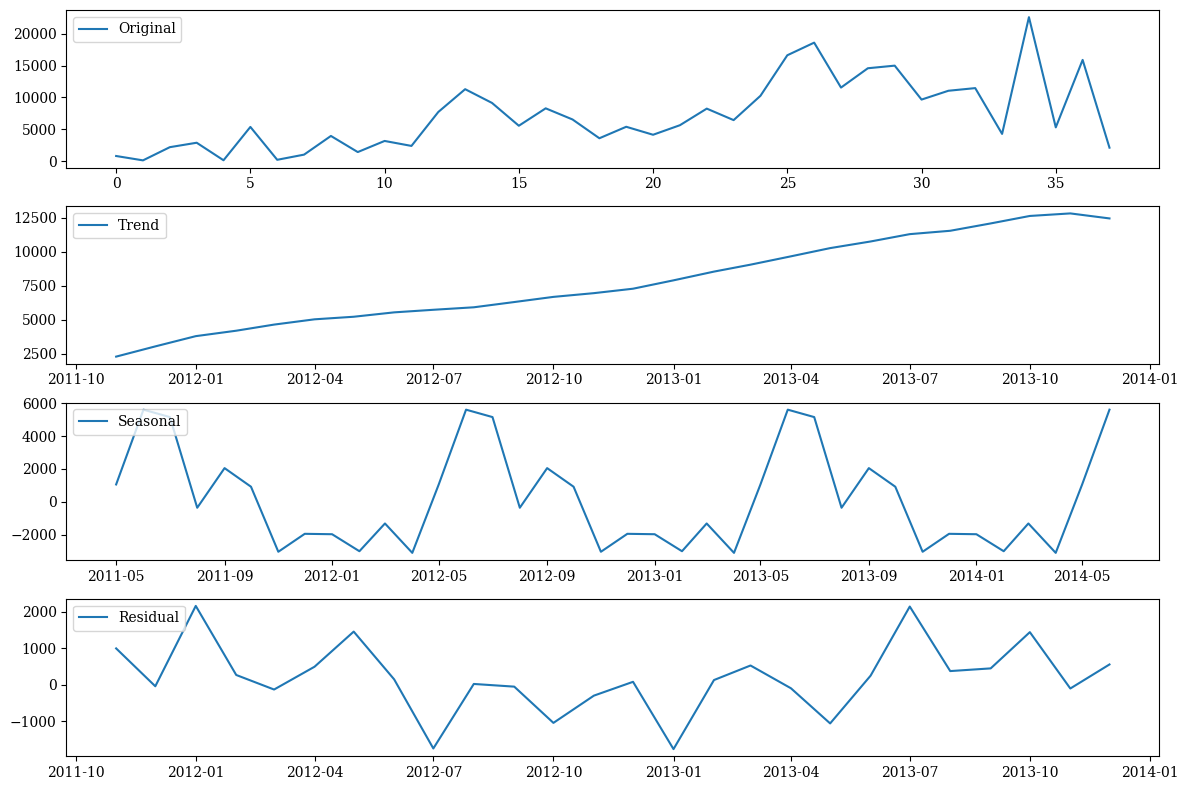

In [26]:
result = seasonal_decompose(monthly_sales.set_index('month')["orderqty"], model='additive', period=12)

def seasonal_decomposition_plots(data: pd.DataFrame, seasonal_decomposition: DecomposeResult):
    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(data['orderqty'], label='Original')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 2)
    plt.plot(seasonal_decomposition.trend, label='Trend')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 3)
    plt.plot(seasonal_decomposition.seasonal, label='Seasonal')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 4)
    plt.plot(seasonal_decomposition.resid, label='Residual')
    plt.legend(loc='upper left')

    plt.tight_layout()

    return plt.show()

seasonal_decomposition_plots(data=monthly_sales, seasonal_decomposition=result)

## Séries Hierárquicas






<blockquote class="callout callout_default" theme="📌">
  <h4>📌 <font color = #0081be><b>1.</b></font> A fim de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima, faça uma previsão sobre a demanda dos próximos 3 meses de cada produto em cada loja. Além disso, aponte se há ou não a presença de sazonalidade em algum produto de sua escolha.</h4>

  * Para analisar a distribuição de produtos, foi empregado o modelo ***AutoARIMA*** para prever a demanda dos próximos três meses para cada produto em cada região e loja.
  * Será considerada a granularidade de subcategoria de produtos, país e loja.
  * Além disso, foi investigado a sazonalidade específica dos produtos do tipo "Bicicletas".
</blockquote>



In [27]:
hts = (
    df
    .groupby([
        'month','product_subcategory_name', 'country_region_name', 'name_store'])["orderqty"].sum()
    .reset_index()
)

hts.head()

,month,product_subcategory_name,country_region_name,name_store,orderqty
0,2011-05-01,Bicicletas de estrada,Canada,Cliente individual,1
1,2011-05-01,Bicicletas de estrada,Canada,General Bike Corporation,3
2,2011-05-01,Bicicletas de estrada,Canada,"Health Spa, Limited",41
3,2011-05-01,Bicicletas de estrada,Canada,Requisite Part Supply,3
4,2011-05-01,Bicicletas de estrada,Canada,Retail Mall,47


In [28]:
hierarchies = [
    ['product_subcategory_name'],
    ['product_subcategory_name', 'country_region_name'],
    ['product_subcategory_name', 'country_region_name', 'name_store'],
]

In [29]:
hts = hts.rename(columns={"month": "ds", "orderqty": "y"})

In [30]:
Y_df, S_df, tags = aggregate(hts, hierarchies)
Y_df = Y_df.reset_index()
Y_df

,unique_id,ds,y
0,Bicicletarios,2013-05-01,221
1,Bicicletarios,2013-06-01,372
2,Bicicletarios,2013-07-01,422
3,Bicicletarios,2013-08-01,222
4,Bicicletarios,2013-09-01,312
...,...,...,...
24679,Suportes para bicicletas/Reino Unido/Cliente i...,2014-02-01,2
24680,Suportes para bicicletas/Reino Unido/Cliente i...,2014-03-01,2
24681,Suportes para bicicletas/Reino Unido/Cliente i...,2014-04-01,4
24682,Suportes para bicicletas/Reino Unido/Cliente i...,2014-05-01,2


**Divisão dos dados em treinamento e teste**

- Foram selecionados os últimos 3 meses para teste

In [31]:
test_agg = Y_df.groupby('unique_id').tail(3)
train_agg = Y_df.drop(test_agg.index)

test_agg = test_agg.set_index('unique_id')
train_agg = train_agg.set_index('unique_id')

### Treinamento do modelo

In [32]:
fcst = StatsForecast(
    df=train_agg,
    models=[AutoARIMA(season_length=3)],
    freq='MS',
    n_jobs=-1
  )

In [33]:
Y_hat_df = fcst.forecast(h=3, fitted=True)

In [34]:
#p_fitted = fcst.forecast_fitted_values()

In [35]:
xmat = pd.merge(left=test_agg.reset_index(), right=Y_hat_df.reset_index(), on=['unique_id', 'ds'])
xmat2 = xmat.copy()

**Previsão sobre a demanda dos próximos 3 meses de cada produto/país/loja**

In [36]:
xmat['ds'] = pd.to_datetime(xmat['ds'])
xmat_filtrado = xmat[xmat['ds'] >= '2014-03-01']
xmat_filtrado = xmat_filtrado.sort_values(by='ds', ascending=True)

xmat_filtrado.columns = ['Produtos', 'Data', 'Real', 'Previsão']

xmat_filtrado.head(20)

,Produtos,Data,Real,Previsão
77,Quadros de turismo,2014-03-01,552,199.000000
481,Quadros de estrada/Estados Unidos,2014-03-01,253,28.017937
479,Quadros de estrada/Canada,2014-03-01,125,13.480997
475,Quadros de estrada/Alemanha,2014-03-01,6,2.791922
1015,Bicicletas de turismo/Alemanha/Cliente individual,2014-03-01,28,24.000000
142,Bicicletas de turismo/Alemanha,2014-03-01,281,84.313454
650,Bicicletas de estrada/Alemanha/Cliente individual,2014-03-01,59,30.000000
1001,Bicicletas de montanha/Reino Unido/Cliente ind...,2014-03-01,47,43.954952
455,Pedaleiras/Franca,2014-03-01,28,0.000000
1824,Coletes/Franca/Cliente individual,2014-03-01,3,6.235294


### Métricas

**Métricas MSE (Erro Quadrático Médio), RMSE (Raiz do Erro Quadrático Médio) e MSA (Erro Absoluto Médio) - AutoArima**

In [37]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x.values,y.values)) ,4))

def my_mse(x, y):
    return np.round(mse(x.values, y.values), 4)

def my_mae(x, y):
    return np.nanmean(abs(x.values -  y.values))

def creating_results(p_rec_):
  results = []
  for k in tags.keys():
      k_rmse = my_rmse(p_rec_.loc[p_rec_['unique_id'].isin(tags[k]), 'y'], p_rec_.loc[p_rec_['unique_id'].isin(tags[k]), 'pred'])
      k_mse = my_mse(p_rec_.loc[p_rec_['unique_id'].isin(tags[k]), 'y'], p_rec_.loc[p_rec_['unique_id'].isin(tags[k]), 'pred'])
      k_mae = my_mae(p_rec_.loc[p_rec_['unique_id'].isin(tags[k]), 'y'], p_rec_.loc[p_rec_['unique_id'].isin(tags[k]), 'pred'])

      results.append({'Category': k, 'RMSE': k_rmse, 'MSE': k_mse, 'MAE': k_mae})
      results_df = pd.DataFrame(results)

  return results_df

In [38]:
xmat2 = xmat.copy()

In [39]:
xmat2.columns = ['unique_id', 'ds', 'y', 'pred']
result_xmat2 = creating_results(xmat2)
result_xmat2.head()

,Category,RMSE,MSE,MAE
0,product_subcategory_name,512.1300,262277.1611,337.069460
1,product_subcategory_name/country_region_name,127.1361,16163.5957,64.970649
2,product_subcategory_name/country_region_name/n...,15.1374,229.1406,8.596041


In [40]:
k_rmse = my_rmse(xmat2['y'], xmat2['pred'])
k_mse = my_mse(xmat2['y'], xmat2['pred'])
k_mae = my_mae(xmat2['y'], xmat2['pred'])

results_arima = {'RMSE': [k_rmse], 'MSE': [k_mse], 'MAE': [k_mae]}
results_df_arima = pd.DataFrame(results_arima)
results_df_arima

,RMSE,MSE,MAE
0,95.2003,9063.1061,24.664065


### Sazonalidade

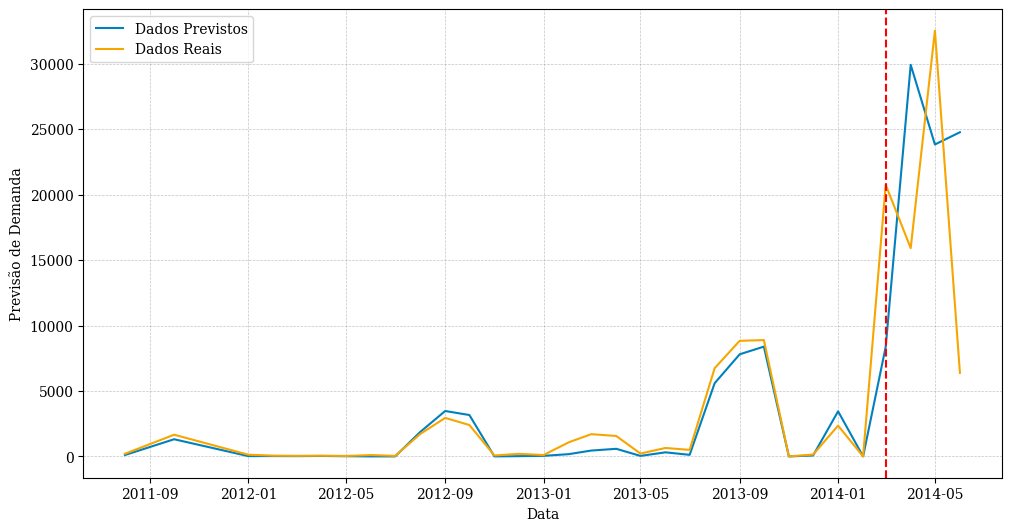

In [41]:
monthly_sales_pred = (
    xmat2
    .groupby("ds")["pred"].sum()
    .reset_index()
)

monthly_sales_y = (
    xmat2
    .groupby("ds")["y"].sum()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')

# Dados Previstos
df_sorted_pred = monthly_sales_pred.sort_values('ds', ascending=True)
xs_pred = df_sorted_pred['ds']
ys_pred = df_sorted_pred['pred']
plt.plot(xs_pred, ys_pred, color=cerulean, label='Dados Previstos')

# Dados Reais
df_sorted_real = monthly_sales_y.sort_values('ds', ascending=True)
xs_real = df_sorted_real['ds']
ys_real = df_sorted_real['y']
plt.plot(xs_real, ys_real, color=web_orange, label='Dados Reais')

# plt.axvline(x='2014-03-01', color='red', linestyle='--')
date_to_plot = pd.to_datetime('2014-03-01')
plt.axvline(x=date_to_plot, color='red', linestyle='--')

plt.xlabel('Data')
plt.ylabel('Previsão de Demanda')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color=neutral_500, alpha=0.5)

plt.show()

**Analisando as vendas do produto 'Bicicletas'**

In [42]:
Y_hat_df_filtered = xmat2[xmat2['unique_id'].str.contains("Bicicletas")]
Y_hat_df_filtered

,unique_id,ds,y,pred
3,Bicicletas de estrada,2014-03-01,2371,938.912109
4,Bicicletas de estrada,2014-04-01,443,995.170166
5,Bicicletas de estrada,2014-05-01,1379,327.635956
6,Bicicletas de montanha,2014-03-01,1868,896.855103
7,Bicicletas de montanha,2014-04-01,404,871.949097
...,...,...,...,...
1130,Bicicletas de turismo/Reino Unido/Exceptional ...,2013-08-01,5,8.000000
1131,Bicicletas de turismo/Reino Unido/Instruments ...,2013-10-01,61,55.000000
1132,Bicicletas de turismo/Reino Unido/Metro Metals...,2013-09-01,78,98.000000
1133,Bicicletas de turismo/Reino Unido/Rampart Amus...,2013-09-01,2,2.000000


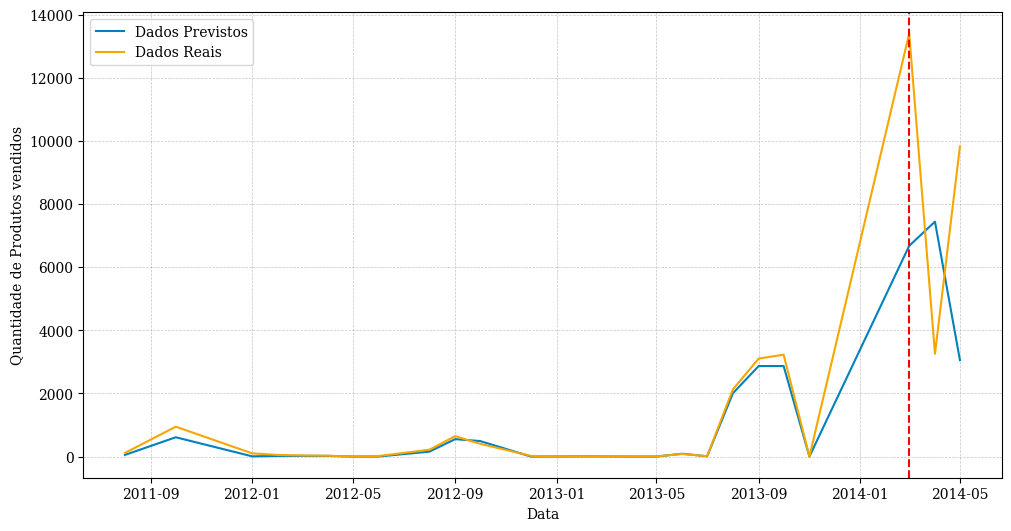

In [43]:
monthly_sales_pred = (
    Y_hat_df_filtered
    .groupby("ds")["pred"].sum()
    .reset_index()
)

monthly_sales_y = (
    Y_hat_df_filtered
    .groupby("ds")["y"].sum()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')

df_sorted_pred = monthly_sales_pred.sort_values('ds', ascending=True)
df_sorted_y = monthly_sales_y.sort_values('ds', ascending=True)

xs_pred = df_sorted_pred['ds']
ys_pred = df_sorted_pred['pred']

xs_y = df_sorted_y['ds']
ys_y = df_sorted_y['y']

plt.plot(xs_pred, ys_pred, color=cerulean, label='Dados Previstos')
plt.plot(xs_y, ys_y, color=web_orange, label='Dados Reais')

date_to_plot = pd.to_datetime('2014-03-01')
plt.axvline(x=date_to_plot, color='red', linestyle='--')

plt.xlabel('Data')
plt.ylabel('Quantidade de Produtos vendidos')

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color=neutral_500, alpha=0.5)

plt.show()

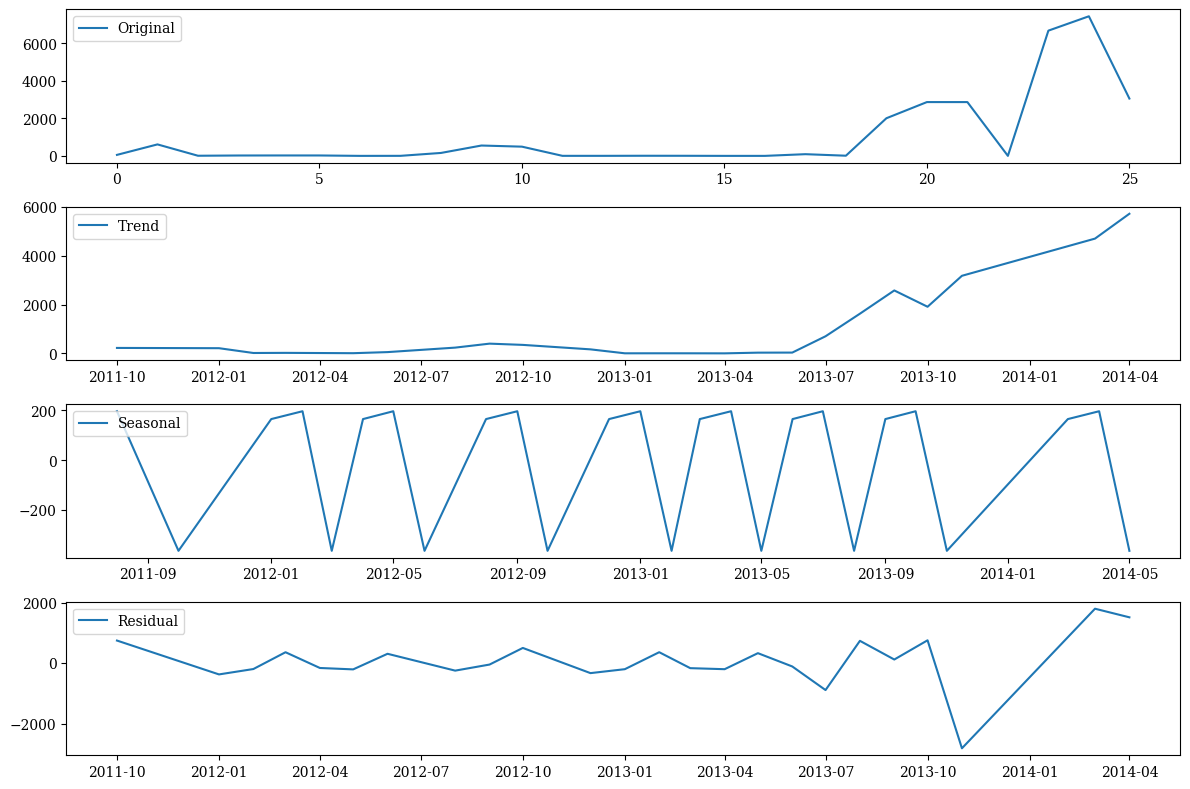

In [44]:
monthly_sales = (
    Y_hat_df_filtered
    .groupby("ds")["pred"].sum()
    .reset_index()
)

result = seasonal_decompose(monthly_sales.set_index('ds')["pred"], model='additive', period=3)

def seasonal_decomposition_plots(data: pd.DataFrame, seasonal_decomposition: DecomposeResult):

    # Plot the original time series, trend, seasonality, and residual
    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(data['pred'], label='Original')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 2)
    plt.plot(seasonal_decomposition.trend, label='Trend')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 3)
    plt.plot(seasonal_decomposition.seasonal, label='Seasonal')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 4)
    plt.plot(seasonal_decomposition.resid, label='Residual')
    plt.legend(loc='upper left')

    plt.tight_layout()

    return plt.show()

seasonal_decomposition_plots(data=monthly_sales, seasonal_decomposition=result)

<blockquote class="callout callout_default" theme="✅">
  <p>✅ Durante a análise, foram abalisadas as métricas de desempenho, incluindo RMSE, MSE e MSA. Além disso, foi identificada a sazonalidade nos padrões de venda do produto 'Bicicletas'.</p>
</blockquote>

## Regressão com XGBoost Regressor

<blockquote class="callout callout_default" theme="📌">
  <h4>📌 <font color = #0081be><b>2.</b></font> Seria possível resolver este problema através de uma abordagem utilizando modelos de regressão? Se sim, qual demonstra melhor resultado? Justifique utilizando métricas de avaliação.</h4>

  * Será empregado o modelo ***XGBoost Regressor*** e será realizada a avaliação pelas métricas de desempenho essenciais, tais como o MSE (Erro Quadrático Médio), RMSE (Raiz do Erro Quadrático Médio) e MSA (Erro Absoluto Médio).
</blockquote>


**Preparação dos Dados**

In [45]:
df2 = df.copy()
df2.head()

,order_date,onlineorderflag,subtotal,taxamt,freight,totaldue,orderqty,unitprice,unitpricediscount,amount_paid_product,...,Manufacturer,Quality,Promotion,Review,Other,Television,product_name,product_subcategory_name,product_category_name,month
0,2012-09-19,True,2071.4196,165.7136,51.7855,2288.9187,1,2071.4196,0.0,2071.4196,...,0,0,0,1,0,0,"Mountain 200 Silver, 38",Bicicletas de montanha,Bicicletas,2012-09-01
1,2013-07-31,False,28920.1932,3183.5746,994.8671,33098.6349,6,72.0000,0.0,432.0000,...,0,0,0,0,0,0,Hitch Rack 4 Bike,Bicicletarios,Acessórios,2013-07-01
2,2013-07-31,False,39566.3847,3803.0664,1188.4582,44557.9093,2,37.2540,0.0,74.5080,...,0,0,0,0,0,0,ML Road Pedal,Pedais,Componentes,2013-07-01
3,2012-07-31,False,48267.6020,4654.3557,1454.4862,54376.4439,6,61.3740,0.0,368.2440,...,0,0,0,0,0,0,ML Headset,Fones de ouvido,Componentes,2012-07-01
4,2013-07-31,False,42858.2133,4653.4965,1454.2177,48965.9275,2,54.9420,0.0,109.8840,...,0,0,0,0,0,0,HL Touring Handlebars,Guidao,Componentes,2013-07-01


In [46]:
df2 = df2.drop('order_date', axis=1)
df2 = df2.drop('onlineorderflag', axis=1)
df2 = df2.drop('makeflag', axis=1)
df2 = df2.drop('finishedgoodsflag', axis=1)
df2 = df2.drop('daystomanufacture', axis=1)
df2 = df2.drop('customer_person_type', axis=1)
df2 = df2.drop('postalcode', axis=1)
df2 = df2.drop('state_province_name', axis=1)
df2 = df2.drop('territory_name', axis=1)
df2 = df2.drop('product_name', axis=1)
df2 = df2.drop('product_category_name', axis=1)
df2 = df2.drop('city', axis=1)

**Agrupamento dos Dados**

In [47]:
hts = (
    df2
    .groupby([
        'month', 'product_subcategory_name', 'country_region_name',
        'name_store'])['subtotal', 'taxamt', 'freight', 'totaldue',
                       'unitprice', 'unitpricediscount', 'amount_paid_product',
                       'standardcost', 'listprice', 'safetystocklevel', 'reorderpoint',
                       'Price', 'Manufacturer', 'Quality', 'Promotion', 'Review',
                       'Other',  'Television', 'orderqty'].sum().reset_index()
)

hts.head()

,month,product_subcategory_name,country_region_name,name_store,subtotal,taxamt,freight,totaldue,unitprice,unitpricediscount,...,safetystocklevel,reorderpoint,Price,Manufacturer,Quality,Promotion,Review,Other,Television,orderqty
0,2011-05-01,Bicicletas de estrada,Canada,Cliente individual,3578.2700,286.2616,89.4568,3953.9884,3578.2700,0.0,...,100,75,0,1,1,0,0,0,0,1
1,2011-05-01,Bicicletas de estrada,Canada,General Bike Corporation,2632.1150,251.6064,78.6270,2962.3484,838.9178,0.0,...,200,150,0,0,0,0,0,0,0,3
2,2011-05-01,Bicicletas de estrada,Canada,"Health Spa, Limited",403655.4046,38852.3044,12141.3446,454649.0536,11148.7712,0.0,...,1400,1050,0,0,0,0,0,0,0,41
3,2011-05-01,Bicicletas de estrada,Canada,Requisite Part Supply,2624.3820,251.9407,78.7315,2955.0542,874.7940,0.0,...,100,75,0,0,0,0,0,0,0,3
4,2011-05-01,Bicicletas de estrada,Canada,Retail Mall,503218.1868,48464.7156,15145.2238,566828.1262,9421.2681,0.0,...,1400,1050,0,0,0,0,0,0,0,47


**Criando uma coluna com as categorias agrupadas**


In [48]:
def concatenar_valores(row):
    return '/'.join(row)

hts['concat'] = hts[['product_subcategory_name', 'country_region_name', 'name_store']].apply(concatenar_valores, axis=1)
hts.head()

,month,product_subcategory_name,country_region_name,name_store,subtotal,taxamt,freight,totaldue,unitprice,unitpricediscount,...,reorderpoint,Price,Manufacturer,Quality,Promotion,Review,Other,Television,orderqty,concat
0,2011-05-01,Bicicletas de estrada,Canada,Cliente individual,3578.2700,286.2616,89.4568,3953.9884,3578.2700,0.0,...,75,0,1,1,0,0,0,0,1,Bicicletas de estrada/Canada/Cliente individual
1,2011-05-01,Bicicletas de estrada,Canada,General Bike Corporation,2632.1150,251.6064,78.6270,2962.3484,838.9178,0.0,...,150,0,0,0,0,0,0,0,3,Bicicletas de estrada/Canada/General Bike Corp...
2,2011-05-01,Bicicletas de estrada,Canada,"Health Spa, Limited",403655.4046,38852.3044,12141.3446,454649.0536,11148.7712,0.0,...,1050,0,0,0,0,0,0,0,41,"Bicicletas de estrada/Canada/Health Spa, Limited"
3,2011-05-01,Bicicletas de estrada,Canada,Requisite Part Supply,2624.3820,251.9407,78.7315,2955.0542,874.7940,0.0,...,75,0,0,0,0,0,0,0,3,Bicicletas de estrada/Canada/Requisite Part Su...
4,2011-05-01,Bicicletas de estrada,Canada,Retail Mall,503218.1868,48464.7156,15145.2238,566828.1262,9421.2681,0.0,...,1050,0,0,0,0,0,0,0,47,Bicicletas de estrada/Canada/Retail Mall


In [49]:
hts = hts.set_index('month')
hts.index = pd.to_datetime(hts.index)

In [50]:
hts2 = hts.drop('concat', axis=1)
df_valores_concatenados = hts.loc[:, ['concat']]

**Codificação de rótulos para variáveis categóricas**

In [51]:
label_encoder = LabelEncoder()
hts2['name_store'] = label_encoder.fit_transform(hts2['name_store'])
hts2['product_subcategory_name'] = label_encoder.fit_transform(hts2['product_subcategory_name'])
hts2['country_region_name'] = label_encoder.fit_transform(hts2['country_region_name'])

df_concat = hts2.copy()

In [52]:
hts2

,product_subcategory_name,country_region_name,name_store,subtotal,taxamt,freight,totaldue,unitprice,unitpricediscount,amount_paid_product,...,safetystocklevel,reorderpoint,Price,Manufacturer,Quality,Promotion,Review,Other,Television,orderqty
month,,,,,,,,,,,,,,,,,,,,,
2011-05-01,1,2,81,3578.2700,286.2616,89.4568,3953.9884,3578.2700,0.0,3578.2700,...,100,75,0,1,1,0,0,0,0,1
2011-05-01,1,2,220,2632.1150,251.6064,78.6270,2962.3484,838.9178,0.0,1258.3767,...,200,150,0,0,0,0,0,0,0,3
2011-05-01,1,2,251,403655.4046,38852.3044,12141.3446,454649.0536,11148.7712,0.0,26116.8423,...,1400,1050,0,0,0,0,0,0,0,41
2011-05-01,1,2,441,2624.3820,251.9407,78.7315,2955.0542,874.7940,0.0,2624.3820,...,100,75,0,0,0,0,0,0,0,3
2011-05-01,1,2,446,503218.1868,48464.7156,15145.2238,566828.1262,9421.2681,0.0,29544.2659,...,1400,1050,0,0,0,0,0,0,0,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-01,32,5,81,193.9700,15.5176,4.8493,214.3369,139.9800,0.0,139.9800,...,8,6,0,0,0,0,1,0,0,2
2014-06-01,33,1,81,846.2400,67.6992,21.1561,935.0953,795.0000,0.0,795.0000,...,20,15,2,0,0,0,0,1,0,5
2014-06-01,33,2,81,383.9500,30.7160,9.5988,424.2648,318.0000,0.0,318.0000,...,8,6,2,0,0,0,0,0,0,2


**Divisão dos dados em treinamento e teste**

In [53]:
train = hts2.loc[hts2.index < '2014-04-01']
test = hts2.loc[hts2.index >= '2014-04-01']

features = ['subtotal', 'taxamt', 'freight', 'totaldue', 'unitprice', 'unitpricediscount',
            'amount_paid_product', 'standardcost', 'listprice', 'safetystocklevel',
            'reorderpoint', 'name_store', 'country_region_name', 'Price', 'Manufacturer',
            'Quality', 'Promotion',  'Review', 'Other', 'Television', 'product_subcategory_name']

target = 'orderqty'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

### Treinamento do modelo

In [54]:
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:25.08717	validation_1-rmse:41.36777
[100]	validation_0-rmse:11.99394	validation_1-rmse:18.86277
[200]	validation_0-rmse:7.23335	validation_1-rmse:10.17626
[300]	validation_0-rmse:5.49849	validation_1-rmse:7.22140
[400]	validation_0-rmse:4.73507	validation_1-rmse:6.08117
[500]	validation_0-rmse:4.31816	validation_1-rmse:5.47171
[600]	validation_0-rmse:4.06670	validation_1-rmse:5.14380
[700]	validation_0-rmse:3.86711	validation_1-rmse:4.93184
[800]	validation_0-rmse:3.69334	validation_1-rmse:4.77179
[900]	validation_0-rmse:3.52936	validation_1-rmse:4.65860
[999]	validation_0-rmse:3.40968	validation_1-rmse:4.56656


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

**Feature Importance**

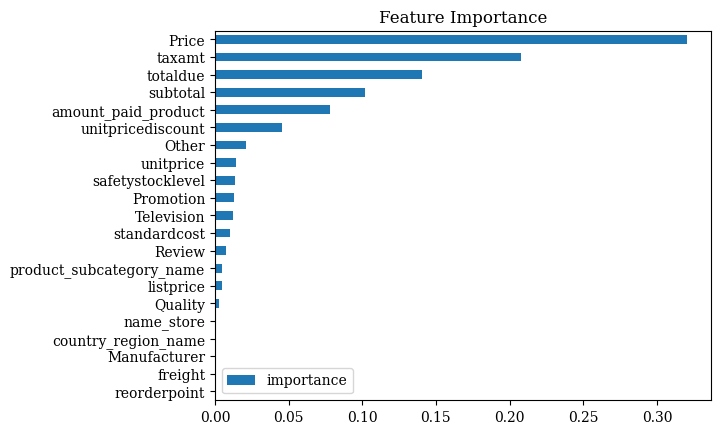

In [55]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Métricas

**Métricas MSE (Erro Quadrático Médio), RMSE (Raiz do Erro Quadrático Médio) e MSA (Erro Absoluto Médio) - AutoArima**

In [56]:
test['prediction'] = reg.predict(X_test)
test['prediction'].reset_index()

,month,prediction
0,2014-04-01,5.751825
1,2014-04-01,8.430125
2,2014-04-01,8.452886
3,2014-04-01,19.418890
4,2014-04-01,6.419940
...,...,...
1362,2014-06-01,3.695933
1363,2014-06-01,7.451045
1364,2014-06-01,4.962737
1365,2014-06-01,6.206259


In [57]:
df1 = hts2.copy()
df1['prediction'] = pd.Series([float('NaN')] * len(df1), index=df1.index)

In [58]:
df1.iloc[-1367:, df1.columns.get_loc('prediction')] = test['prediction'].values
df1

,product_subcategory_name,country_region_name,name_store,subtotal,taxamt,freight,totaldue,unitprice,unitpricediscount,amount_paid_product,...,reorderpoint,Price,Manufacturer,Quality,Promotion,Review,Other,Television,orderqty,prediction
month,,,,,,,,,,,,,,,,,,,,,
2011-05-01,1,2,81,3578.2700,286.2616,89.4568,3953.9884,3578.2700,0.0,3578.2700,...,75,0,1,1,0,0,0,0,1,NaN
2011-05-01,1,2,220,2632.1150,251.6064,78.6270,2962.3484,838.9178,0.0,1258.3767,...,150,0,0,0,0,0,0,0,3,NaN
2011-05-01,1,2,251,403655.4046,38852.3044,12141.3446,454649.0536,11148.7712,0.0,26116.8423,...,1050,0,0,0,0,0,0,0,41,NaN
2011-05-01,1,2,441,2624.3820,251.9407,78.7315,2955.0542,874.7940,0.0,2624.3820,...,75,0,0,0,0,0,0,0,3,NaN
2011-05-01,1,2,446,503218.1868,48464.7156,15145.2238,566828.1262,9421.2681,0.0,29544.2659,...,1050,0,0,0,0,0,0,0,47,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-01,32,5,81,193.9700,15.5176,4.8493,214.3369,139.9800,0.0,139.9800,...,6,0,0,0,0,1,0,0,2,3.695933
2014-06-01,33,1,81,846.2400,67.6992,21.1561,935.0953,795.0000,0.0,795.0000,...,15,2,0,0,0,0,1,0,5,7.451045
2014-06-01,33,2,81,383.9500,30.7160,9.5988,424.2648,318.0000,0.0,318.0000,...,6,2,0,0,0,0,0,0,2,4.962737


In [59]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x.values,y.values)) ,4))

def my_mse(x, y):
    return np.round(mse(x.values, y.values), 4)

def my_mae(x, y):
    return np.nanmean(abs(x.values -  y.values))

In [60]:
k_rmse = my_rmse(test['orderqty'], test['prediction'])
k_mse = my_mse(test['orderqty'], test['prediction'])
k_mae = my_mae(test['orderqty'], test['prediction'])

results_xgboost = {'RMSE': [k_rmse], 'MSE': [k_mse], 'MAE': [k_mae]}
results_df_xgboost = pd.DataFrame(results_xgboost)
results_df_xgboost

,RMSE,MSE,MAE
0,4.5666,20.8535,2.394331


In [61]:
df_resultado_metricas = pd.concat([results_df_arima, results_df_xgboost], ignore_index=True)
df_resultado_metricas = df_resultado_metricas.rename(index={0: 'AutoARIMA', 1: 'XGBoost'})

df_resultado_metricas.head()

,RMSE,MSE,MAE
AutoARIMA,95.2003,9063.1061,24.664065
XGBoost,4.5666,20.8535,2.394331


**Previsão sobre a demanda dos próximos 3 meses de cada produto/país/loja**

In [62]:
df_concat['produto/pais/loja'] = df_valores_concatenados['concat']

In [63]:
df_concat

,product_subcategory_name,country_region_name,name_store,subtotal,taxamt,freight,totaldue,unitprice,unitpricediscount,amount_paid_product,...,reorderpoint,Price,Manufacturer,Quality,Promotion,Review,Other,Television,orderqty,produto/pais/loja
month,,,,,,,,,,,,,,,,,,,,,
2011-05-01,1,2,81,3578.2700,286.2616,89.4568,3953.9884,3578.2700,0.0,3578.2700,...,75,0,1,1,0,0,0,0,1,Bicicletas de estrada/Canada/Cliente individual
2011-05-01,1,2,220,2632.1150,251.6064,78.6270,2962.3484,838.9178,0.0,1258.3767,...,150,0,0,0,0,0,0,0,3,Bicicletas de estrada/Canada/General Bike Corp...
2011-05-01,1,2,251,403655.4046,38852.3044,12141.3446,454649.0536,11148.7712,0.0,26116.8423,...,1050,0,0,0,0,0,0,0,41,"Bicicletas de estrada/Canada/Health Spa, Limited"
2011-05-01,1,2,441,2624.3820,251.9407,78.7315,2955.0542,874.7940,0.0,2624.3820,...,75,0,0,0,0,0,0,0,3,Bicicletas de estrada/Canada/Requisite Part Su...
2011-05-01,1,2,446,503218.1868,48464.7156,15145.2238,566828.1262,9421.2681,0.0,29544.2659,...,1050,0,0,0,0,0,0,0,47,Bicicletas de estrada/Canada/Retail Mall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-01,32,5,81,193.9700,15.5176,4.8493,214.3369,139.9800,0.0,139.9800,...,6,0,0,0,0,1,0,0,2,Shorts/Reino Unido/Cliente individual
2014-06-01,33,1,81,846.2400,67.6992,21.1561,935.0953,795.0000,0.0,795.0000,...,15,2,0,0,0,0,1,0,5,Suportes para bicicletas/Australia/Cliente ind...
2014-06-01,33,2,81,383.9500,30.7160,9.5988,424.2648,318.0000,0.0,318.0000,...,6,2,0,0,0,0,0,0,2,Suportes para bicicletas/Canada/Cliente indivi...


In [64]:
df_concat['prediction'] = pd.Series([float('NaN')] * len(df_concat), index=df_concat.index)

df_concat.iloc[-1367:, df_concat.columns.get_loc('prediction')] = test['prediction'].values
df_concat

,product_subcategory_name,country_region_name,name_store,subtotal,taxamt,freight,totaldue,unitprice,unitpricediscount,amount_paid_product,...,Price,Manufacturer,Quality,Promotion,Review,Other,Television,orderqty,produto/pais/loja,prediction
month,,,,,,,,,,,,,,,,,,,,,
2011-05-01,1,2,81,3578.2700,286.2616,89.4568,3953.9884,3578.2700,0.0,3578.2700,...,0,1,1,0,0,0,0,1,Bicicletas de estrada/Canada/Cliente individual,NaN
2011-05-01,1,2,220,2632.1150,251.6064,78.6270,2962.3484,838.9178,0.0,1258.3767,...,0,0,0,0,0,0,0,3,Bicicletas de estrada/Canada/General Bike Corp...,NaN
2011-05-01,1,2,251,403655.4046,38852.3044,12141.3446,454649.0536,11148.7712,0.0,26116.8423,...,0,0,0,0,0,0,0,41,"Bicicletas de estrada/Canada/Health Spa, Limited",NaN
2011-05-01,1,2,441,2624.3820,251.9407,78.7315,2955.0542,874.7940,0.0,2624.3820,...,0,0,0,0,0,0,0,3,Bicicletas de estrada/Canada/Requisite Part Su...,NaN
2011-05-01,1,2,446,503218.1868,48464.7156,15145.2238,566828.1262,9421.2681,0.0,29544.2659,...,0,0,0,0,0,0,0,47,Bicicletas de estrada/Canada/Retail Mall,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-01,32,5,81,193.9700,15.5176,4.8493,214.3369,139.9800,0.0,139.9800,...,0,0,0,0,1,0,0,2,Shorts/Reino Unido/Cliente individual,3.695933
2014-06-01,33,1,81,846.2400,67.6992,21.1561,935.0953,795.0000,0.0,795.0000,...,2,0,0,0,0,1,0,5,Suportes para bicicletas/Australia/Cliente ind...,7.451045
2014-06-01,33,2,81,383.9500,30.7160,9.5988,424.2648,318.0000,0.0,318.0000,...,2,0,0,0,0,0,0,2,Suportes para bicicletas/Canada/Cliente indivi...,4.962737


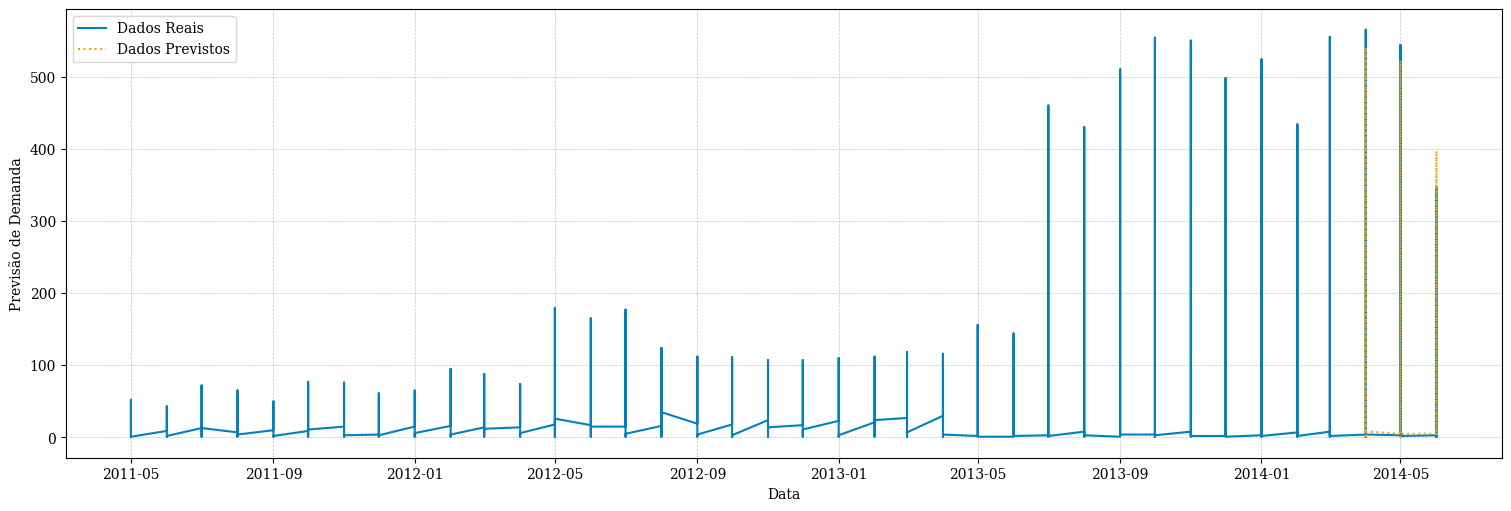

In [65]:
fig, ax = plt.subplots(figsize=(15, 5), layout='constrained')

# Dados Reais
plt.plot(df_concat[['orderqty']], color=cerulean, label='Dados Reais')

# Dados Previstos
plt.plot(df_concat['prediction'], color=web_orange, linestyle='dotted', label='Dados Previstos')

date_to_plot = pd.to_datetime('2014-03-01')

plt.xlabel('Data')
plt.ylabel('Previsão de Demanda')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color=neutral_500, alpha=0.5)

plt.show()

<blockquote class="callout callout_default" theme="✅">
  <p>✅ Durante a análise das métricas de desempenho  entre os modelos AutoARIMA e XGBoost, pode-se observar diferenças significativas em suas performances. O modelo para o XGBoost apresentou resultados consideravelmente menores do que os do AutoARIMAm indicando uma melhor adaptação do modelo aos dados observados.</p>
</blockquote>

## Análise pelos Centros de Distribuição



<blockquote class="callout callout_default" theme="📌">
  <h4>📌 <font color = #0081be><b>3.</b></font> Os novos centros de distribuição passaram a ser divididos em províncias nos EUA e em países no resto do mundo. Qual desses grupos apresentou mais crescimento em demanda nos três meses previstos no item 1?</h4>

  * Para determinar quais centros de distribuição tiveram o maior crescimento na demanda nos últimos três meses, foi calculado o crescimento absoluto da demanda para os Estados Unidos e para os países do resto do mundo.
  * Para isso, vamos utilizar os dados previstos utilizando o modelo ***XGBoost***.
  * Além disso, foram comparados os valores resultantes para identificar o grupo que registrou o maior aumento total na demanda.
</blockquote>


In [66]:
demanda_anterior = '2014-01-01'
demanda_prevista = '2014-06-30'

df_selected = df_concat.loc[demanda_anterior:demanda_prevista]
df_selected

,product_subcategory_name,country_region_name,name_store,subtotal,taxamt,freight,totaldue,unitprice,unitpricediscount,amount_paid_product,...,Price,Manufacturer,Quality,Promotion,Review,Other,Television,orderqty,produto/pais/loja,prediction
month,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0,0,81,962.730,77.0184,24.0683,1063.8167,360.00,0.0,360.00,...,3,0,0,0,0,0,0,3,Bicicletarios/Alemanha/Cliente individual,NaN
2014-01-01,0,0,127,28722.156,2745.5721,857.9913,32325.7194,72.00,0.0,360.00,...,0,0,0,0,0,0,0,5,Bicicletarios/Alemanha/Educational Services,NaN
2014-01-01,0,0,466,28953.564,2768.2894,865.0904,32586.9438,72.00,0.0,144.00,...,0,0,0,0,0,0,0,2,Bicicletarios/Alemanha/Rodeway Bike Store,NaN
2014-01-01,0,1,46,21439.446,2045.9863,639.3707,24124.8030,72.00,0.0,360.00,...,0,0,0,0,0,0,0,5,Bicicletarios/Australia/Bike Part Wholesalers,NaN
2014-01-01,0,1,81,2954.890,236.3912,73.8724,3265.1536,600.00,0.0,600.00,...,3,0,0,0,1,0,0,5,Bicicletarios/Australia/Cliente individual,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-01,32,5,81,193.970,15.5176,4.8493,214.3369,139.98,0.0,139.98,...,0,0,0,0,1,0,0,2,Shorts/Reino Unido/Cliente individual,3.695933
2014-06-01,33,1,81,846.240,67.6992,21.1561,935.0953,795.00,0.0,795.00,...,2,0,0,0,0,1,0,5,Suportes para bicicletas/Australia/Cliente ind...,7.451045
2014-06-01,33,2,81,383.950,30.7160,9.5988,424.2648,318.00,0.0,318.00,...,2,0,0,0,0,0,0,2,Suportes para bicicletas/Canada/Cliente indivi...,4.962737


In [67]:
df_new = df_selected[['produto/pais/loja', 'orderqty', 'prediction']].copy()
df_new

,produto/pais/loja,orderqty,prediction
month,,,
2014-01-01,Bicicletarios/Alemanha/Cliente individual,3,NaN
2014-01-01,Bicicletarios/Alemanha/Educational Services,5,NaN
2014-01-01,Bicicletarios/Alemanha/Rodeway Bike Store,2,NaN
2014-01-01,Bicicletarios/Australia/Bike Part Wholesalers,5,NaN
2014-01-01,Bicicletarios/Australia/Cliente individual,5,NaN
...,...,...,...
2014-06-01,Shorts/Reino Unido/Cliente individual,2,3.695933
2014-06-01,Suportes para bicicletas/Australia/Cliente ind...,5,7.451045
2014-06-01,Suportes para bicicletas/Canada/Cliente indivi...,2,4.962737


**Selecionando os registros dos EUA e dos outros países**

In [68]:
df_usa = df_new[df_new['produto/pais/loja'].str.contains('Estados Unidos')]
df_outros_paises = df_new[~df_new['produto/pais/loja'].str.contains('Estados Unidos')]

In [69]:
def calcular_crescimento_demanda(df):
    df_anterior = df.loc['2014-01-01':'2014-03-01']
    demanda_anterior = df_anterior['orderqty'].sum()

    df_seguinte = df.loc['2014-04-01':'2014-06-01']
    previsao_seguinte = df_seguinte['prediction'].sum()

    crescimento_demanda = previsao_seguinte - demanda_anterior

    resultados = pd.DataFrame({
        'Demanda Anterior': [demanda_anterior],
        'Previsão de Demanda para Próximos 3 Meses': [round(previsao_seguinte)],
        'Crescimento de Demanda': [round(crescimento_demanda)]
    })

    return resultados

In [70]:
# Demanda para os centros de distribuição dos EUA
result_usa = calcular_crescimento_demanda(df_usa)
result_usa.head()

,Demanda Anterior,Previsão de Demanda para Próximos 3 Meses,Crescimento de Demanda
0,18303,10021,-8282


In [71]:
# Demanda para os centros de distribuição de outros países
result_outros_paises = calcular_crescimento_demanda(df_outros_paises)
result_outros_paises.head()

,Demanda Anterior,Previsão de Demanda para Próximos 3 Meses,Crescimento de Demanda
0,20029,13153,-6876


In [72]:
df_resultado_centros = pd.concat([result_usa, result_outros_paises], ignore_index=True)
df_resultado_centros = df_resultado_centros.rename(index={0: 'EUA', 1: 'Outros Países'})

df_resultado_centros.head()

,Demanda Anterior,Previsão de Demanda para Próximos 3 Meses,Crescimento de Demanda
EUA,18303,10021,-8282
Outros Países,20029,13153,-6876


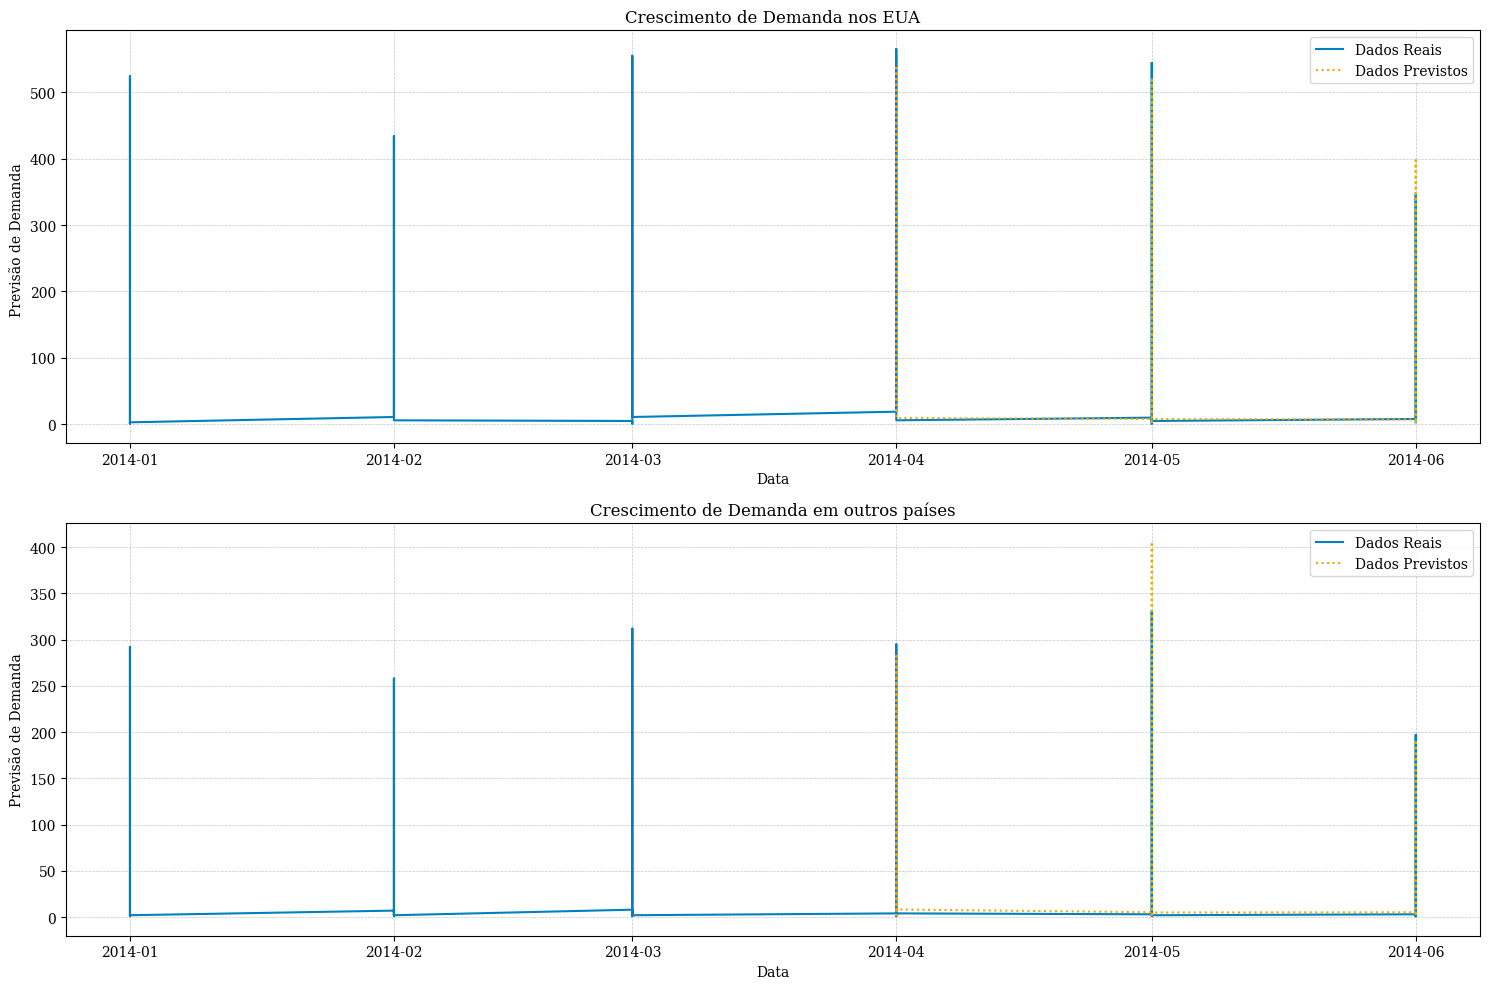

In [73]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

axes[0].plot(df_usa['orderqty'], color=cerulean, label='Dados Reais')
axes[0].plot(df_usa['prediction'], color=web_orange, linestyle='dotted', label='Dados Previstos')
axes[0].set_title('Crescimento de Demanda nos EUA')
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Previsão de Demanda ')
axes[0].legend()
axes[0].grid(True, linestyle='--', linewidth=0.5, color=neutral_500, alpha=0.5)

axes[1].plot(df_outros_paises['orderqty'], color=cerulean, label='Dados Reais')
axes[1].plot(df_outros_paises['prediction'], color=web_orange, linestyle='dotted', label='Dados Previstos')
axes[1].set_title('Crescimento de Demanda em outros países')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Previsão de Demanda')
axes[1].legend()
axes[1].grid(True, linestyle='--', linewidth=0.5, color=neutral_500, alpha=0.5)

plt.tight_layout()
plt.show()

<blockquote class="callout callout_default" theme="✅">
  <p>✅ Assim, é possível constatar que houve uma queda na previsão de demanda dos próximos 3 meses. Mas, o centros de distribuição localizados nos EUA apresentam uma demanda para os produtos maior do que os novos centros de distribuição localizados em outros países.</p>
</blockquote>

## Análise previsão de demanda de luvas

<blockquote class="callout callout_default" theme="📌">
  <h4>📌 <font color = #0081be><b>4.</b></font> Um novo fornecedor de luvas, que agora engloba toda a produção mundial, precisa ter uma estimativa de quantos zíperes precisa pedir para os próximos 3 meses. Levando em consideração que são necessários 2 zíperes por par, quantos seriam necessários?</h4>
</blockquote>

In [74]:
data_inicial = '2014-04-01'
data_final = '2014-06-30'

df_selected = df_concat.loc[data_inicial:data_final]

df_new = df_selected[['produto/pais/loja', 'orderqty', 'prediction']].copy()
df_luvas = df_new[df_new['produto/pais/loja'].str.contains('Luvas')]
df_luvas

,produto/pais/loja,orderqty,prediction
month,,,
2014-04-01,Luvas/Alemanha/Bicycle Warehouse Inc.,8,5.817273
2014-04-01,Luvas/Alemanha/Cliente individual,13,12.835428
2014-04-01,Luvas/Australia/Cliente individual,22,23.497341
2014-04-01,Luvas/Canada/Cliente individual,21,20.062426
2014-04-01,Luvas/Estados Unidos/Cliente individual,65,63.644333
2014-04-01,Luvas/Franca/Cliente individual,11,10.934797
2014-04-01,Luvas/Reino Unido/Cliente individual,15,14.327637
2014-05-01,Luvas/Alemanha/Cliente individual,7,5.949233
2014-05-01,Luvas/Alemanha/Educational Services,3,3.663228


In [75]:
estimativa_demanda_luvas = df_luvas['prediction'].sum()
pares = estimativa_demanda_luvas / 2
estimativa_demanda_ziperes = estimativa_demanda_luvas

print(f'O fornecedor tem uma estimativa de {round(estimativa_demanda_ziperes)} zíperes necessários para {round(pares)} pares para os próximos 3 meses.')

O fornecedor tem uma estimativa de 603 zíperes necessários para 301 pares para os próximos 3 meses.


In [76]:
estimativa_demanda_luvas = df_luvas['prediction'].sum()
estimativa_demanda_luvas2 = estimativa_demanda_luvas / 2

<blockquote class="callout callout_default" theme="✅">
  <p>✅ Portanto, o novo fornecedor de luvas precisa pedir 603 zíperes para os próximos 3 meses.</p>
</blockquote>